In [1]:
import time
import numpy as np
import torch

from sbi import utils as utils
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import homogeneous_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2
    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [3]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Homo SIR

In [4]:
homo_sir = homogeneous_sir.HomoSIR()

## Data generation

In [196]:
# DON'T NEED TO RUN AGAIN IF YOU ALREADY GENERATED THE REFERENCE DATA
N = 50000

homo_sir_theta_npe_large = homo_sir.sample_theta([N]).reshape(-1, 1)
homo_sir_x_npe_large = torch.empty([N, 1])
for i in range(N):
    homo_sir_x_npe_large[i, :] = homo_sir(homo_sir_theta_npe_large[i])

# Observed data generation
homo_sir_obs_theta = torch.tensor([5])
homo_sir_obs_x = homo_sir(homo_sir_obs_theta)

torch.save(homo_sir_x_npe_large, "data/homo_sir_x_npe_large.pt")
torch.save(homo_sir_theta_npe_large, "data/homo_sir_theta_npe_large.pt")
torch.save(homo_sir_obs_x, "data/homo_sir_obs_x.pt")
torch.save(homo_sir_obs_theta, "data/homo_sir_obs_theta.pt")

## Data loading

In [5]:
homo_sir_x_npe_large = torch.load("data/homo_sir_x_npe_large.pt", weights_only=True)
homo_sir_theta_npe_large = torch.load("data/homo_sir_theta_npe_large.pt", weights_only=True)

homo_sir_obs_x = torch.load("data/homo_sir_obs_x.pt", weights_only=True)
homo_sir_obs_theta = torch.load("data/homo_sir_obs_theta.pt", weights_only=True)

## Fit GP

In [6]:
n_train_pair = 100 # number of pairs used to fit GP
n_rep = 10 # number of repeats to get the average cost

In [ ]:
# Simulate the cost
X = homo_sir_theta_npe_large[:n_train_pair]
times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = homo_sir(homo_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = (et - st) / n_rep

# save GP training samples
torch.save(X, "data/homo_sir_gp_x.pt")
torch.save(times_train, "data/homo_sir_gp_y.pt")

In [53]:
# Train a GP
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 50
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')

torch.save({'model_state_dict': model.state_dict(), 'likelihood_state_dict': likelihood.state_dict()}, 'data/homo_sir_gp.pth')

Iter 1/50 - Loss: 0.8623600006103516
Iter 2/50 - Loss: 0.8193010091781616
Iter 3/50 - Loss: 0.7764698266983032
Iter 4/50 - Loss: 0.7338752746582031
Iter 5/50 - Loss: 0.6914833188056946
Iter 6/50 - Loss: 0.6491745114326477
Iter 7/50 - Loss: 0.6067185997962952
Iter 8/50 - Loss: 0.5638237595558167
Iter 9/50 - Loss: 0.5202581286430359
Iter 10/50 - Loss: 0.4759351313114166
Iter 11/50 - Loss: 0.43090149760246277
Iter 12/50 - Loss: 0.38528403639793396
Iter 13/50 - Loss: 0.33924034237861633
Iter 14/50 - Loss: 0.29292720556259155
Iter 15/50 - Loss: 0.2464725524187088
Iter 16/50 - Loss: 0.19994987547397614
Iter 17/50 - Loss: 0.1533590704202652
Iter 18/50 - Loss: 0.10663307458162308
Iter 19/50 - Loss: 0.059685975313186646
Iter 20/50 - Loss: 0.012482071295380592
Iter 21/50 - Loss: -0.03492317348718643
Iter 22/50 - Loss: -0.0823875442147255
Iter 23/50 - Loss: -0.1297263354063034
Iter 24/50 - Loss: -0.17677658796310425
Iter 25/50 - Loss: -0.223459392786026
Iter 26/50 - Loss: -0.2698022425174713
Iter

In [8]:
state_dicts = torch.load('data/homo_sir_gp.pth', weights_only=True) # Load GP params

# Load GP data
X = torch.load("data/homo_sir_gp_x.pt", weights_only=True)
times_train = torch.load("data/homo_sir_gp_y.pt", weights_only=True)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

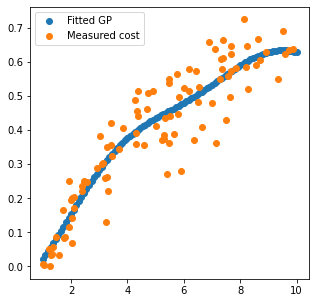

In [9]:
x_test = torch.linspace(1, 10, 100).reshape(-1, 1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_test)).mean

plt.figure(figsize=[5,5])
plt.scatter(x_test, observed_pred, label="Fitted GP")
plt.scatter(X, times_train, label="Measured cost")
plt.legend()
plt.show()

In [69]:
prior_start = torch.tensor([1.]).reshape(-1, 1)
prior_end = torch.tensor([10.]).reshape(-1, 1)

g_min = likelihood(model(prior_start)).mean
g_max = likelihood(model(prior_end)).mean

print("g_min with k=0.5: ", (g_min ** 0.5).item())
print("g_min with k=1: ", (g_min ** 1).item())
print("g_min with k=2: ", (g_min ** 2).item())

print("g_max with k=0.5: ", (g_max ** 0.5).item())
print("g_max with k=1: ", (g_max ** 1).item())
print("g_max with k=2: ", (g_max ** 2).item())

g_min with k=0.5:  0.14984974265098572
g_min with k=1:  0.022454947233200073
g_min with k=2:  0.0005042246775701642
g_max with k=0.5:  0.7929415106773376
g_max with k=1:  0.6287562847137451
g_max with k=2:  0.3953344523906708


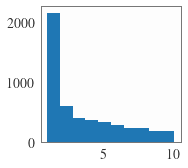

In [11]:
k = 1

num_sim = 5000
theta_tilde = torch.zeros([num_sim, 1])
count = 0
while count < num_sim:
    theta = homo_sir.sample_theta([1]).reshape(-1, 1)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1

w = likelihood(model(theta_tilde)).mean.detach() ** k

plt.hist(theta_tilde.detach().numpy(), bins=10)
plt.show()

## CEG ESS

In [15]:
num_sim = 2000
num_repeats = 1
k = np.array([0, 0.2, 0.4, 0.5, 1.0, 2.0]) # Exponent of the penaly function g(z) = z^k

ess_cost_aware = np.zeros([k.size, num_repeats])
ceg = np.zeros([k.size, num_repeats])

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:
            theta = homo_sir.sample_theta([num_sim])
            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros([num_sim, 1])
            count = 0
            while count < num_sim:
                param_value = homo_sir.sample_theta([1]).reshape(-1, 1)
                if calc_acc_prob(model, likelihood, param_value, prior_start, k[ind]) > torch.rand(1):
                    theta_tilde[count] = param_value.reshape(-1)
                    count += 1

            w_u = likelihood(model(theta_tilde)).mean.detach() ** k[ind]   # self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(likelihood(model(theta)).mean.detach()) / torch.mean(likelihood(model(theta_tilde)).mean.detach())
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim

print(ess_cost_aware * ceg)

## Train reference NPE

In [109]:
# DON'T NEED TO RUN
homo_sir_inference_npe_large = SNPE_C()
homo_sir_nn_npe_large = homo_sir_inference_npe_large.append_simulations(
    homo_sir_theta_npe_large, homo_sir_x_npe_large).train()

homo_sir_post_npe_large = homo_sir_inference_npe_large.build_posterior(homo_sir_nn_npe_large, prior=homo_sir.prior)
homo_sir_samples_npe_large = homo_sir_post_npe_large.sample((1000,), x=homo_sir_obs_x)

torch.save(homo_sir_samples_npe_large, "data/homo_sir_post_reference.pt")

In [10]:
# Load the reference NPE
homo_sir_post_reference = torch.load("data/homo_sir_post_reference.pt", weights_only=True)

## Statistics over multiple runs

In [11]:
# NPE results

n_run = 50
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 1])
cost_npe = torch.zeros([n_run])

for i in range(n_run):
    checkpoint_path = f"sims/homo_sir/1.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=homo_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], homo_sir_post_reference, lengthscale=median_heuristic(homo_sir_post_reference))

mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")

NPE MMD mean 0.02 (std 0.02)


In [14]:
def get_results(k, n_run):

    mmd_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 1])
    cost_canpe = torch.zeros([n_run])
    cost_saved = torch.zeros([n_run])
    
    for i in range(n_run):
        checkpoint_path = f"sims/homo_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

        posterior_canpe = checkpoint["posterior_canpe"]
        
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=homo_sir_obs_x, show_progress_bars=False)
        
        mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], homo_sir_post_reference, lengthscale=median_heuristic(homo_sir_post_reference))
        cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
        cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
        
        cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]

    mmd_canpe = mmd_canpe.detach().numpy() 
    mmd_canpe_mean = np.mean(mmd_canpe)
    mmd_canpe_std = np.std(mmd_canpe)
    
    cost_canpe = cost_canpe.detach().numpy() 
    cost_canpe_mean = np.mean(cost_canpe)
    cost_canpe_std = np.std(cost_canpe)
    
    cost_saved = cost_saved.detach().numpy()
    cost_saved_mean = np.mean(cost_saved)
    cost_saved_std = np.std(cost_saved)
    
    print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")
    # print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")
    print(f"Cost saved: {cost_saved_mean:.2f}(std {cost_saved_std:.2f})")

In [15]:
get_results('0.5', 50)

CA-NPE MMD mean 0.01 (std 0.01)
Cost saved: 0.17(std 0.01)


In [16]:
get_results('1.0', 50)

CA-NPE MMD mean 0.02 (std 0.02)
Cost saved: 0.39(std 0.02)


In [17]:
get_results('2.0', 50)

CA-NPE MMD mean 0.23 (std 0.08)
Cost saved: 0.70(std 0.02)


In [18]:
get_results('mixture', 50)

CA-NPE MMD mean 0.04 (std 0.03)
Cost saved: 0.30(std 0.02)


# Cost plot

In [88]:
n_rep = 50

lamb = torch.arange(1, 10, 0.3)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(lamb)).mean

In [ ]:
N = lamb.shape[0]
homo_lamb = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = homo_sir(lamb[i].reshape(-1))
    et = time.time()
    homo_lamb[i] = (et - st) / n_rep

print(homo_lamb)

torch.save(homo_lamb, "data/homo_cost.pt")

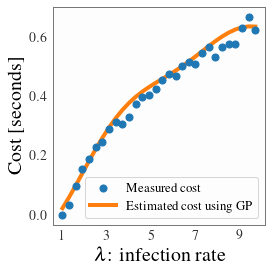

In [90]:
homo_lamb = torch.load("data/homo_cost.pt")
# Plotting figure
plt.figure(figsize=(4, 4))
plt.scatter(lamb, homo_lamb, s=50, label="Measured cost")
plt.plot(lamb, observed_pred, color="C1", linewidth=4, zorder=0, label="Estimated cost using GP")
# plt.suptitle("        Homogeneous SIR", fontsize=20)
plt.xlabel("$\\lambda$: infection rate", fontsize=20)
plt.ylabel("Cost [seconds]", fontsize=20)
plt.legend(fontsize=13)
plt.xticks([1, 3, 5, 7, 9])

# plt.grid()
plt.tight_layout()
plt.savefig("figures/plot_cost_homo_sir.pdf")
plt.show()